In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

from local.lib.bisicles_defaults import X0LEV, Y0LEV

In [3]:
obs = xr.open_dataset('/Users/jonniebarnsley/data/ICESat2/dhdt/ais_dhdt_grounded_filt_bisicles_8km.nc')
dhdt_obs = obs['dhdt_obs'].values

In [4]:
# Calculate divuh at the end of the relaxation run
bike = xr.open_dataset('/Users/jonniebarnsley/Downloads/inversion_run001/ppe_run001_0lev.nc').isel(time=-1)

uh = bike.xVel * bike.thickness
vh = bike.yVel * bike.thickness
n, m = bike.thickness.shape
uh = uh.values
vh = vh.values

divuh = np.zeros((n,m))
dx = bike.x[1] - bike.x[0] # 8km
dx = dx.values

divuh[1:n-1,1:m-1]  = 0.5/dx *( 
    (uh[1:n-1,2:m] - uh[1:n-1,0:m-2]) + 
    (vh[2:n,1:m-1] - vh[0:n-2,1:m-1]))

Text(0.5, 1.0, 'Modelled flux divergence')

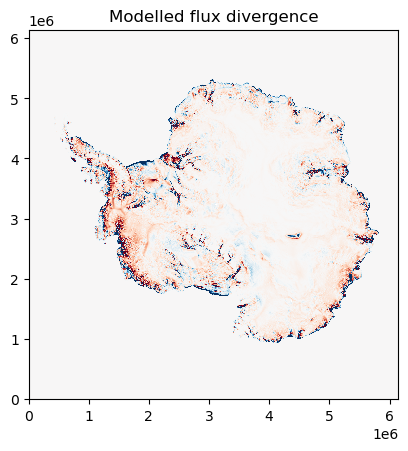

In [18]:
plt.pcolormesh(X0LEV, Y0LEV, divuh, vmax=3, vmin=-3, cmap='RdBu_r')
plt.gca().set_aspect('equal')
plt.title('Modelled flux divergence')

Text(0.5, 1.0, 'Modelled dHdt')

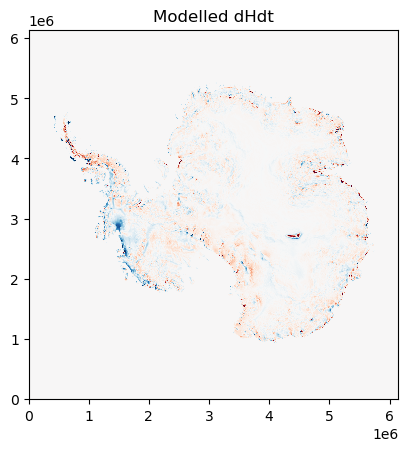

In [21]:
plt.pcolormesh(X0LEV, Y0LEV, bike.dThicknessdt, vmax=3, vmin=-3, cmap='RdBu_r')
plt.gca().set_aspect('equal')
plt.title('Modelled dHdt')

Text(0.5, 1.0, '$divuh_{model} + dH/dt_{obs}$')

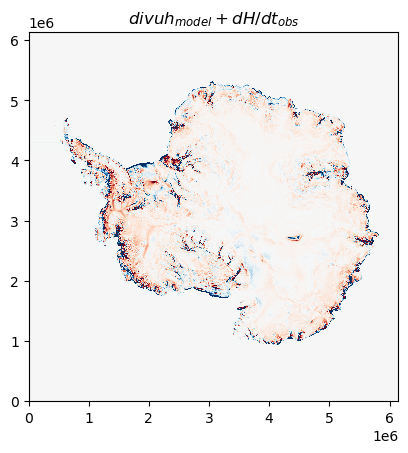

In [24]:
total = divuh + dhdt_obs
plt.pcolormesh(X0LEV, Y0LEV, total, vmax=3, vmin=-3, cmap='RdBu_r')
plt.gca().set_aspect('equal')
plt.title('$divuh_{model} + dH/dt_{obs}$')

In [25]:
ice_density = 917.0  # kg/m^3
ocean_density = 1028.0  # kg/m^3
grounded_mask = bike.thickness > -bike.Z_base * ocean_density / ice_density

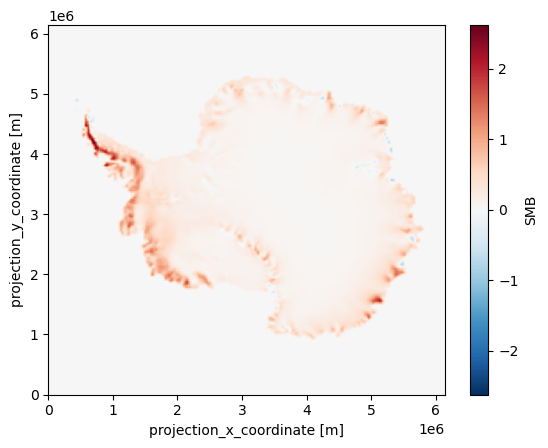

In [26]:
mar = xr.open_dataset('/Users/jonniebarnsley/data/MAR/antarctica.mon-SMB-MAR_ERA5-1980-2021.mean.smb.nc').SMB
mar.plot()

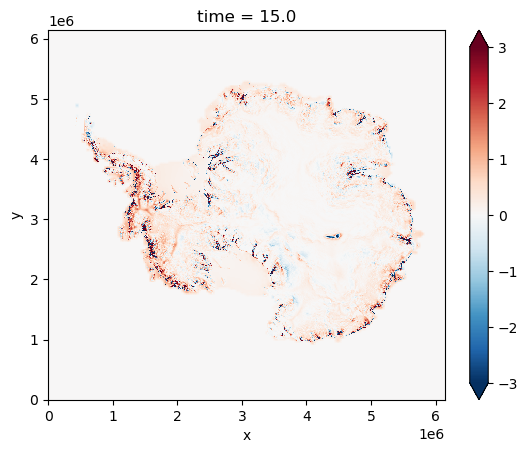

In [27]:
smb = np.where(grounded_mask, total, mar)
smb_da = xr.DataArray(smb, coords=bike.thickness.coords, dims=bike.thickness.dims)
smb_da.plot(vmax=3, vmin=-3, cmap='RdBu_r')

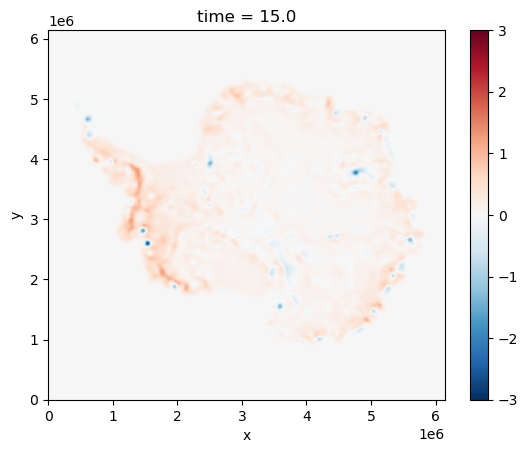

In [ ]:
from scipy.ndimage import gaussian_filter
MAX_SMB = 2.0  # m/a
MIN_SMB = -1.0  # m/a
smb_da = np.where(smb < MIN_SMB, MIN_SMB, smb)
smb = np.where(smb > MAX_SMB, MAX_SMB, smb)
smooth = gaussian_filter(smb_da.fillna(0), sigma=4)
smooth_da = xr.DataArray(smooth, coords=bike.thickness.coords, dims=bike.thickness.dims)
smooth_da.plot(vmax=3, vmin=-3, cmap='RdBu_r')

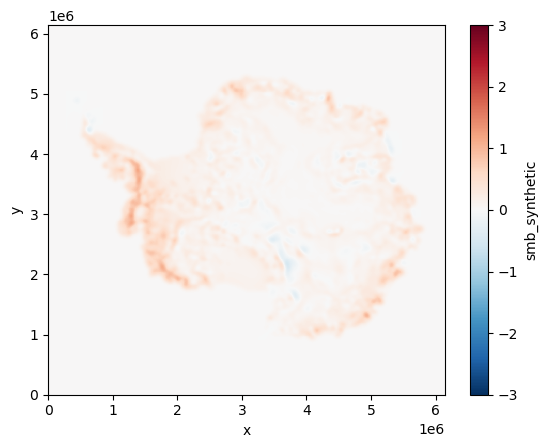

In [39]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/test_synthetic_smb.nc')
file['smb_synthetic'].plot(vmax=3, vmin=-3, cmap='RdBu_r')

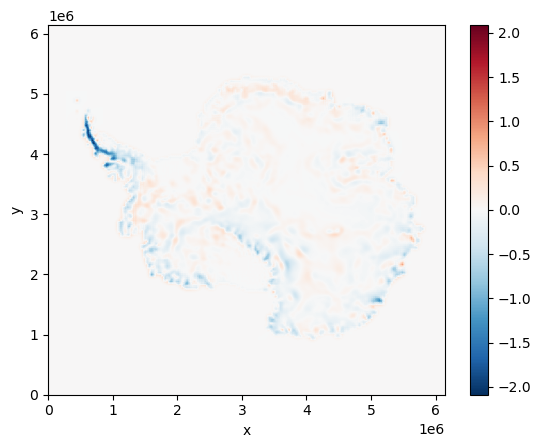

In [40]:
diff = file['smb_synthetic'] - mar
diff.plot()